In [30]:
import sys
import os
from threading import Thread

import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.circuit.library import Initialize

from q_alchemy_sdk_py.qiskit import QAlchemyInitialize, OptParams

sys.path.append('..')
os.environ["Q_ALCHEMY_API_KEY"] = "<your api key>"

In [2]:
def plot_digits(digits, labels, text, matrix_dim):
    _, axes = plt.subplots(nrows=1, ncols=len(digits), figsize=(20, 10), squeeze=False)
    for ax, digit, label in zip(axes.reshape(-1), digits, labels):
        ax.set_axis_off()
        image = digit[:int(matrix_dim**2)].reshape(matrix_dim, matrix_dim)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
        ax.set_title(label)

    plt.show()

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser="auto")

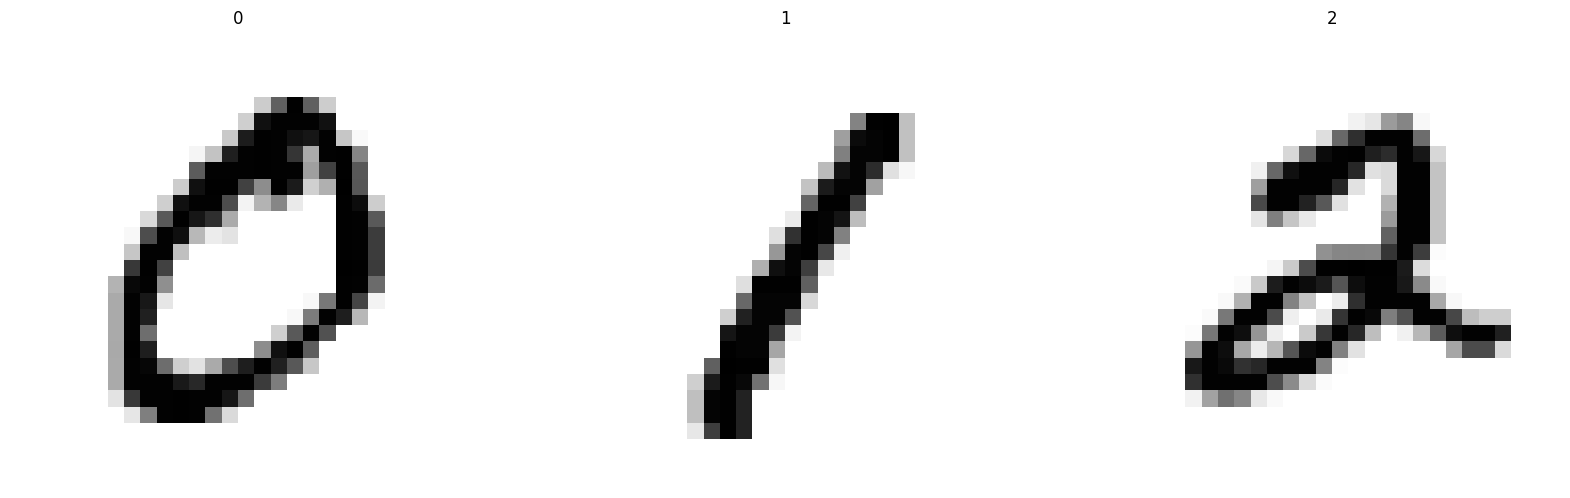

In [4]:
zero: np.ndarray = mnist.data[mnist.target == "0"].iloc[0].to_numpy()
one: np.ndarray = mnist.data[mnist.target == "1"].iloc[0].to_numpy()
two: np.ndarray = mnist.data[mnist.target == "2"].iloc[0].to_numpy()

filler = np.empty(2**10 - zero.shape[0])
filler.fill(0)

zero = np.hstack([zero, filler])
one = np.hstack([one, filler])
two = np.hstack([two, filler])

zero = zero / np.linalg.norm(zero)
one = one / np.linalg.norm(one)
two = two / np.linalg.norm(two)

plot_digits([zero, one, two], [0, 1, 2], "test", 28)

In [5]:
instr = QAlchemyInitialize(
    params=zero.tolist(), 
    opt_params=OptParams(
        max_fidelity_loss=0.1, 
        basis_gates=["id", "rx", "ry", "rz", "cx"]
    ))

In [6]:
instr.definition.draw(fold=-1)

┌──────────────┐                                      ┌────────┐   ┌─────────┐  ┌───────────┐  ┌─────────┐    ┌────────┐   ┌───────┐  ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                                    ┌───┐ ┌────────────┐  ┌─────────┐  ┌────────────┐ ┌─────────┐  ┌────────────┐                              ┌───┐  ┌─────────┐    ┌─────────┐  ┌────────────┐┌─────────┐  ┌────────┐  ┌────────┐┌─────────┐ ┌────────────┐  ┌─────────┐     ┌────────┐                                                            ┌─────────┐    ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                             ┌──────────┐  ┌─────────┐  ┌────────────┐ ┌─────────┐     ┌────────┐                                ┌──────────┐  ┌─────────┐  ┌────────────┐ ┌─────────┐  ┌────────┐ ┌────────┐┌─────────┐ ┌────────────┐ ┌─────────┐    ┌────────┐                              ┌─────────┐    ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                     ┌──────────┐  ┌─────────┐  ┌────────────┐ ┌─────────┐    ┌────────┐                         ┌─────────┐   ┌─────────┐  ┌────────────┐ ┌─────────┐     ┌────────┐   ┌─────────────┐ ┌─────────┐  ┌────────────┐ ┌─────────┐  ┌────────────┐                             ┌───┐ ┌────────────┐  ┌─────────┐  ┌────────────┐┌─────────┐ ┌────────────┐                 ┌───┐┌──────────────┐ ┌─────────┐  ┌───────────┐ ┌─────────┐┌────────────┐  ┌────────┐   ┌─────────┐   ┌────────────┐ ┌─────────┐    ┌────────┐                                            ┌─────────┐    ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                                   ┌──────────┐    ┌─────────┐   ┌────────────┐ ┌─────────┐    ┌────────┐                                                    ┌─────────┐   ┌─────────┐  ┌────────────┐ ┌─────────┐     ┌────────┐     ┌────────┐   ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                                 ┌───┐    ┌──────────────┐ ┌─────────┐  ┌───────────┐  ┌─────────┐  ┌────────────┐┌───┐┌────────────┐┌─────────┐ ┌────────────┐  ┌─────────┐  ┌────────────┐                          ┌───┐ ┌──────────┐ ┌─────────┐ ┌────────────┐  ┌─────────┐     ┌────────┐    ┌───────┐     ┌─────────┐  ┌────────────┐ ┌─────────┐    ┌──────────┐                                                                                  ┌──────────┐  ┌─────────┐  ┌────────────┐ ┌─────────┐    ┌────────┐                                  ┌────────┐    ┌─────────┐   ┌────────────┐  ┌─────────┐     ┌────────┐    ┌────────┐   ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                              ┌───┐     ┌──────────────┐ ┌─────────┐  ┌───────────┐  ┌─────────┐  ┌────────────┐    ┌───┐     ┌────────────┐┌─────────┐ ┌────────────┐┌─────────┐ ┌────────────┐     ┌───┐      ┌──────────┐  ┌─────────┐  ┌────────────┐┌─────────┐ ┌────────┐ ┌────────┐  ┌─────────┐   ┌────────────┐  ┌─────────┐   ┌──────────┐                                                                                                                                                                                         ┌─────────┐   ┌─────────┐ ┌────────────┐┌─────────┐ ┌──────────┐                ┌──────────┐  ┌─────────┐  ┌────────────┐  ┌─────────┐     ┌────────┐                                                          ┌────────┐    ┌─────────┐  ┌────────────┐ ┌─────────┐    ┌────────┐    ┌───────┐    ┌─────────┐  ┌────────────┐ ┌─────────┐  ┌──────────┐                               ┌───┐   ┌────────────┐┌─────────┐┌───────────┐ ┌─────────┐ ┌────────────┐                             ┌───┐     ┌──────────┐  ┌─────────┐  ┌────────────┐ ┌─────────┐    ┌────────┐    ┌───────┐   ┌─────────┐ ┌────────────┐  ┌─────────┐    ┌──────────┐                                                                                                                                                          ┌─────────┐   ┌─────────┐ ┌────────────┐┌─────────┐  ┌──────────┐                                ┌──────────┐  ┌─────────┐  ┌────

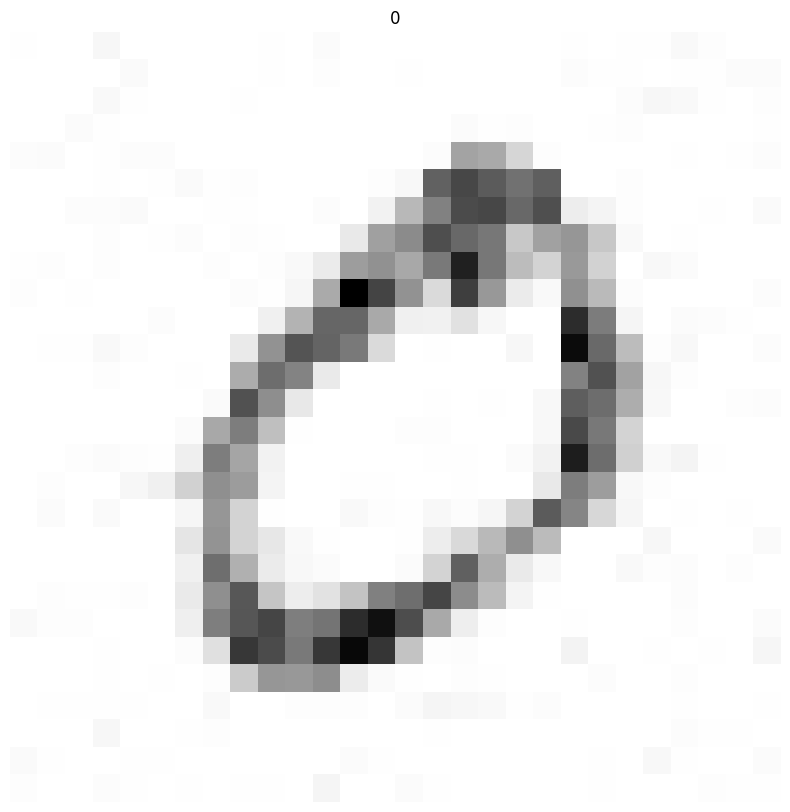

In [7]:
data = Statevector(instr.definition).data
data = np.real(data * data.conj())
plot_digits([data], [0], "test", 28)

# Looking at the 0

In [31]:
def get_comparison_data(d: np.ndarray):
    
    print("Qiskit Benchmark")
    qs_org = Initialize(d.tolist())
    qs_qc = transpile(qs_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    state = Statevector(qs_qc).data.copy()
    state = np.real(state * state.conj())
    cx_length = len(qs_qc.get_instructions("cx"))
    
    threads = []
    result = [
        [-1.0, cx_length, state]
    ]
    for fidelity_loss in np.linspace(0.0, 1.0, 11):
        def func(fl):
            fl = np.round(fl, decimals=1)
            sp_org = QAlchemyInitialize(
                params=d.tolist(),
                opt_params=OptParams(
                    max_fidelity_loss=fl, 
                    basis_gates=["id", "rx", "ry", "rz", "cx"]
                )
            )
            print(f"Starting {fl}")
            qc = sp_org.definition
            sp_length = len(qc.get_instructions("cx"))
            sp_state = Statevector(qc).data.copy()
            sp_state = np.real(sp_state * sp_state.conj())
            print(f"Done {fl}")
            result.append([fl, sp_length, sp_state])
        job = Thread(target=func, args=(fidelity_loss,))
        job.start()
        threads.append(job)

    print(f"Waiting for {len(threads)} jobs to finish.")
    for x in threads: 
        x.join()
    
    return result

In [32]:
def plot_comparison(r):
    meta_data: np.ndarray = np.asarray([r[0:2] for r in r])
    sorting = meta_data[:, 0].argsort()
    meta_data = meta_data[sorting]
    
    image_data: np.ndarray = np.asarray([r[2] for r in r])
    image_data = image_data[sorting]
    
    labels = [f"{r[0]:.1f} @ {r[1]:n}cx" for r in meta_data]
    plot_digits(image_data, labels, "test", 28)

In [39]:
result_zero = get_comparison_data(zero)

Qiskit Benchmark
Waiting for 11 jobs to finish.
Starting 0.1
Starting 0.0
Starting 0.3
Starting 0.2
Starting 0.4
Starting 0.5
Starting 0.7
Starting 0.6
Starting 0.8
Starting 1.0
Starting 0.9
Done 0.8
Done 1.0
Done 0.9
Done 0.7
Done 0.6
Done 0.3
Done 0.5
Done 0.0
Done 0.2
Done 0.4
Done 0.1


In [34]:
result_one = get_comparison_data(one)

Qiskit Benchmark
Waiting for 11 jobs to finish.
Starting 0.1
Starting 0.0
Starting 0.2
Starting 0.3
Starting 0.4
Starting 0.5
Starting 0.7
Starting 0.8
Starting 0.6
Starting 1.0
Starting 0.9
Done 0.8
Done 0.4
Done 0.6
Done 0.3
Done 0.2
Done 0.7
Done 1.0
Done 0.1
Done 0.5
Done 0.9
Done 0.0


In [35]:
result_two = get_comparison_data(two)

Qiskit Benchmark
Waiting for 11 jobs to finish.
Starting 0.0
Starting 0.1
Starting 0.3
Starting 0.2
Starting 0.4
Starting 0.5
Starting 0.6
Starting 0.9
Starting 0.8
Starting 0.7
Starting 1.0
Done 0.0
Done 0.7
Done 0.6
Done 0.5
Done 0.9
Done 0.4
Done 1.0
Done 0.8
Done 0.1
Done 0.2
Done 0.3


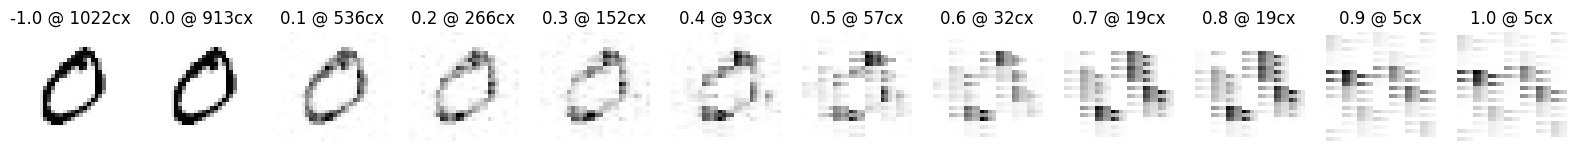

In [40]:
plot_comparison(result_zero)

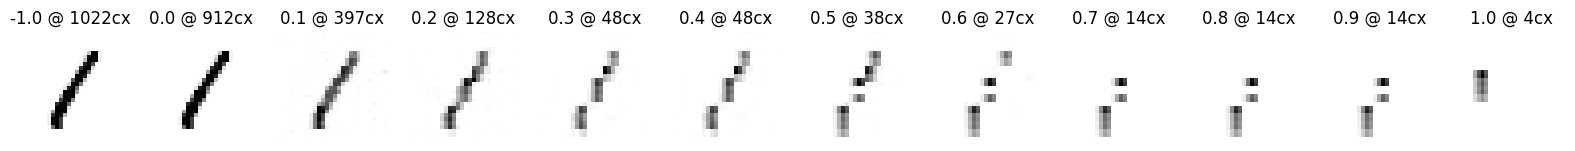

In [37]:
plot_comparison(result_one)

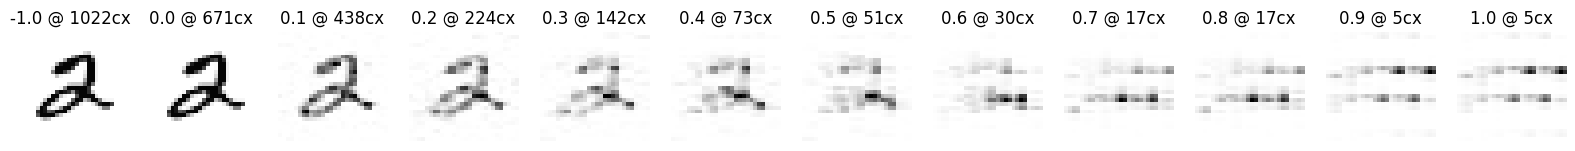

In [38]:
plot_comparison(result_two)